# 1-C Nonlinear Covid-19 Epidemic Model and Prediction 

A Julia implementation of following J-P Quadrat's papers:
- [1-C Nonlinear Covid-19 Epidemic Model and Application to the Epidemic Prediction in France](https://www.medrxiv.org/content/10.1101/2020.05.24.20111807v1)
- [A simple Covid-19 Epidemic Model and Containment Policy in France](https://www.medrxiv.org/content/10.1101/2020.04.25.20079434v1)

In [1]:
using HTTP, Plots, DifferentialEquations;

## Utility functions

In [2]:
# Load a CSV file and convert it into a dictionary structure where
# dictionary keys are country unique identifier (ie name) and
# dictionary data are vector of accumulated infected people over time.
#
# file: CSV file
# k: the column holding the key (ie country names)
# v: the column holding the accumulated infected people (total cases)
# Return the dictionary String => Vector{Float}
function load(file::AbstractString; k::Int, v::Int)
    dic = Dict{String, Array{Float64,1}}()
    open(file, "r") do data_file
        # Ignore the CSV header
        readline(data_file)
        # For each line of the CSV file ...
        rows = readlines(data_file)
        for row in rows
            # ... Extract columns
            entries = split(strip(row), ",")
            
            # dictionary key: country identifier
            key = entries[k]
 
            # dictionary val: convert string to float if value exists.
            # If no value is given: get the last data of non empty array
            # else (no value is given + empty array) set to 0.0 but this
            # value will be not be taken into account anyway.
            val = 0.0
            if entries[v] != ""
                val = parse(Float64, entries[v])
            elseif haskey(dic, key)
                val = dic[key][end]
            end

            # Avoid initial data when the slope is almost 0
            if val > 30.0
                if !haskey(dic, key)
                    dic[key] = [val]
                else
                    append!(dic[key], val)
                end
            end
        end
    end
    dic
end

load (generic function with 1 method)

In [3]:
# One day step derivation
function derivative(y)
    DT = 1;                # Delta Time = 1 day
    M = size(y, 1);        # Number of elements
    y0 = y[1:M-DT];
    y1 = y[1+DT:M];
    return (y1 .- y0) ./ DT;
end

derivative (generic function with 1 method)

In [4]:
# Facade to plot() function: show over days daily infected people and
# prediction of coming infected people.
#
# simulated: prediction of daily infected
# observed: real daily infected
# title: title of the plot
# position: position of the legend
function RecipesBase.plot(simulated, observed, title, position=:topright)
    plot(observed,
        title = title,
        xlabel = "Days",
        ylabel = "Daily Infected",
        label = "observation",
        legend = position)
    plot!(simulated, label="Prediction")
end

## Covid-19 Epidemic Model and Prediction

In [5]:
# Given r, get the a and b coefs of: a * log(accumul)^r + b
# where: accumul is the accumulation of infected people.
# return: a and b coefs and the initial value for the solver.
function model(accumul, r)
    # Logarithm of accumulated infected people
    accumul = log.(accumul)
    
    # Linear regression: y = a x + b
    x, y = accumul[1:end-1] .^ r, derivative(accumul)
    b, a = [ones(size(x, 1)) x] \ y
    
    return b, a, accumul[1]
end

model (generic function with 1 method)

In [6]:
# ODE
function simulation(f::Function, u0, tend, days)
    tspan = (0.0, tend)
    prob = ODEProblem(f, u0, tspan)
    sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)
    
    # Solution up to X days:
    tend = tend + days
    derivative(exp.(sol(1:tend)))
end

simulation (generic function with 1 method)

In [7]:
# First wave prediction
# accumul: accumulated contamined-tested people.
# r: a * log(accumul)^r + b (default: 1)
# days: previtions up to X days (default: 1 month)
# title: title of the plot
# position: position of the legend (default: top right)
function prediction(accumul; r=1.0, days=30, title, position=:topright)
    b, a, u0 = model(accumul, r)
    f(u, p, t) = (u .^ r) .* a .+ b
    sim = simulation(f, u0, size(accumul, 1), days)
    plot(sim, derivative(accumul), title, position)
end

prediction (generic function with 1 method)

In [8]:
# Multi waves prediction (Work in progress)
# TODO: sous echantillone accumul: 1 point par semaine puis changer derivee pour
# prendre la moyenne entre les deux points
function prediction2(accumul; r=1.0, p=30, days=7, title, position=:topright)
    sim = zeros(size(accumul,1) + days)
    for i = 1:size(accumul,1)-p
        b, a, u0 = model(accumul[i:i+p], r)
        f(u, p, t) = (u .^ r) .* a .+ b
        res = simulation(f, u0, size(accumul[i:i+p], 1), days)
        sim[i+p+days] = res[end]
    end
    plot(sim, derivative(accumul), title, position)
end

prediction2 (generic function with 1 method)

## Observations by country

In [9]:
csv_file = HTTP.download("https://covid.ourworldindata.org/data/owid-covid-data.csv", update_period=Inf)

"/tmp/owid-covid-data.csv"

In [10]:
accumulated = load(csv_file, k=3, v=5)

Dict{String,Array{Float64,1}} with 196 entries:
  "Peru"               => [38.0, 43.0, 71.0, 86.0, 117.0, 145.0, 234.0, 263.0, …
  "Indonesia"          => [34.0, 69.0, 96.0, 117.0, 134.0, 172.0, 172.0, 227.0,…
  "Gabon"              => [33.0, 44.0, 46.0, 49.0, 57.0, 57.0, 75.0, 87.0, 95.0…
  "Bangladesh"         => [33.0, 39.0, 39.0, 48.0, 48.0, 48.0, 49.0, 49.0, 51.0…
  "Kosovo"             => [31.0, 33.0, 61.0, 63.0, 71.0, 86.0, 92.0, 95.0, 98.0…
  "Tajikistan"         => [32.0, 76.0, 230.0, 293.0, 379.0, 461.0, 522.0, 612.0…
  "Ethiopia"           => [35.0, 38.0, 43.0, 44.0, 52.0, 55.0, 56.0, 65.0, 69.0…
  "Dominican Republic" => [34.0, 112.0, 202.0, 245.0, 312.0, 392.0, 488.0, 581.…
  "South Sudan"        => [34.0, 34.0, 35.0, 45.0, 45.0, 46.0, 46.0, 52.0, 74.0…
  "Vietnam"            => [34.0, 38.0, 39.0, 44.0, 53.0, 53.0, 57.0, 61.0, 68.0…
  "Guernsey"           => [34.0, 36.0, 39.0, 45.0, 45.0, 60.0, 78.0, 91.0, 114.…
  "Libya"              => [35.0, 48.0, 49.0, 49.0, 49.0, 49.0

## Simulations

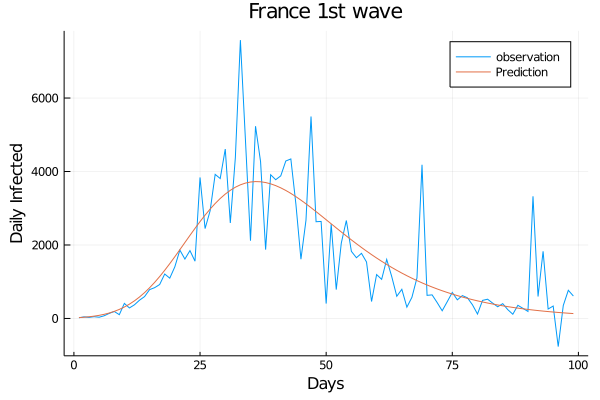

In [11]:
prediction(accumulated["France"][1:100], r=2.0, days=0, title="France 1st wave")

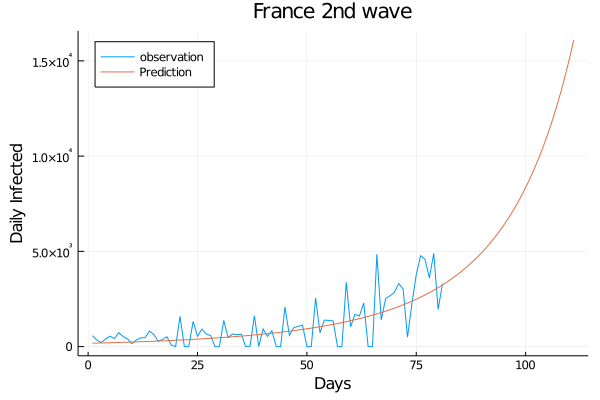

In [12]:
prediction(accumulated["France"][100:end], r=1.0, days=30, title="France 2nd wave", position=:topleft)

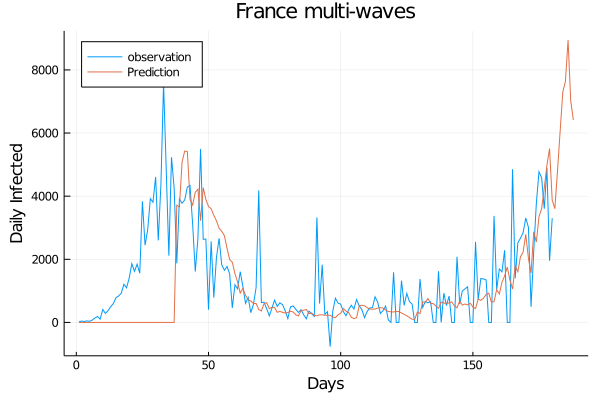

In [13]:
# Work in progress: probably incorrect !!!
prediction2(accumulated["France"][1:end], r=2.0, p=30, days=7, title="France multi-waves", position=:topleft)

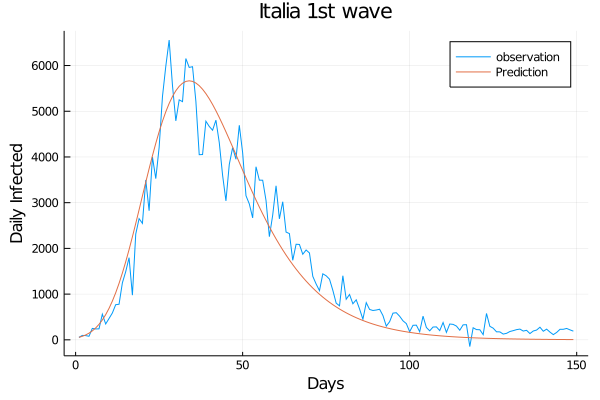

In [14]:
prediction(accumulated["Italy"][1:150], r=1.8, days=0, title="Italia 1st wave")

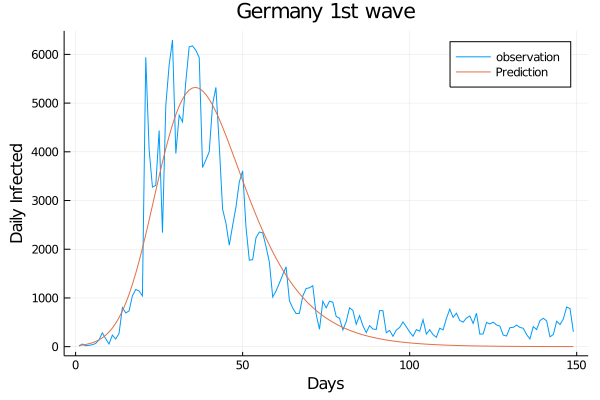

In [15]:
prediction(accumulated["Germany"][1:150], r=3.0, days=0, title="Germany 1st wave")

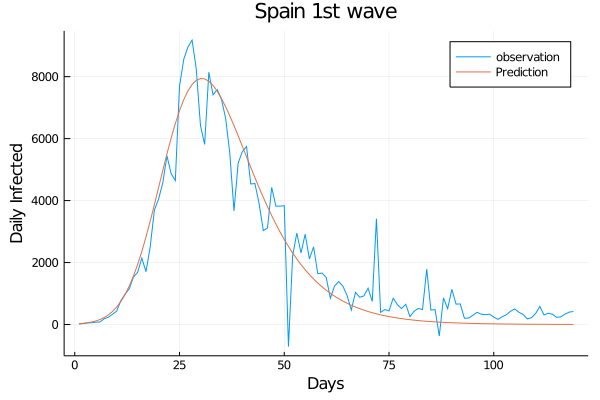

In [16]:
prediction(accumulated["Spain"][1:120], r=3.0, days=0, title="Spain 1st wave")

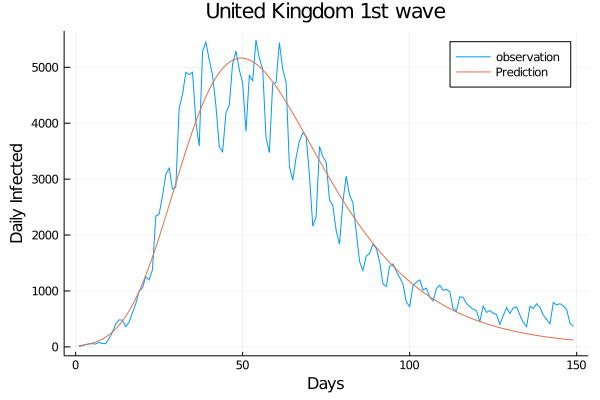

In [17]:
prediction(accumulated["United Kingdom"][1:150], r=1.5, days=0, title="United Kingdom 1st wave")

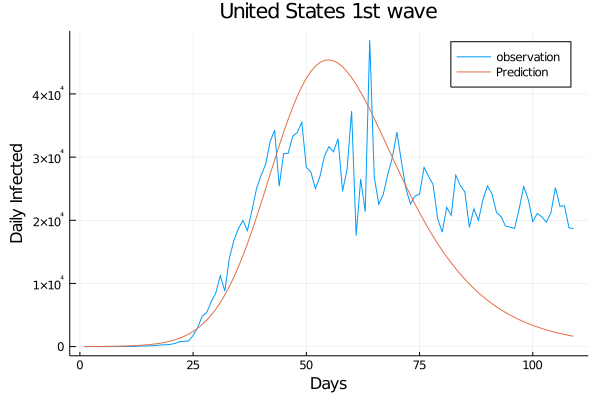

In [18]:
prediction(accumulated["United States"][1:110], r=5.0, days=0, title="United States 1st wave")

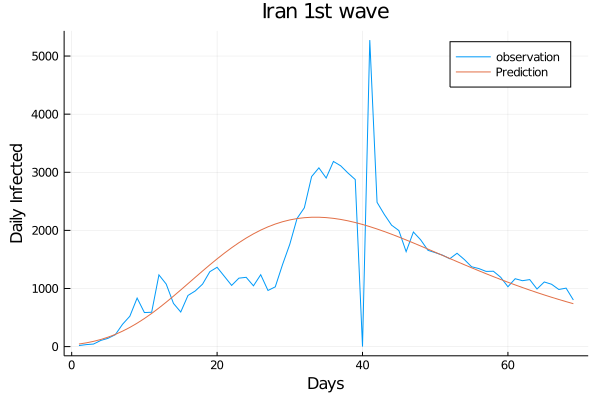

In [19]:
prediction(accumulated["Iran"][1:70], r=0.5, days=0, title="Iran 1st wave")

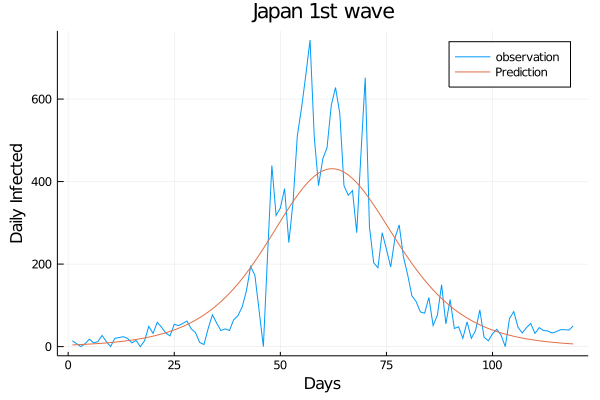

In [20]:
prediction(accumulated["Japan"][1:120], r=10.0, days=0, title="Japan 1st wave")

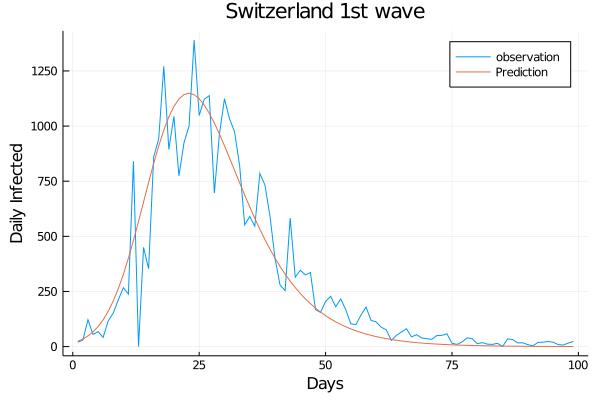

In [21]:
prediction(accumulated["Switzerland"][1:100], r=3.0, days=0, title="Switzerland 1st wave")

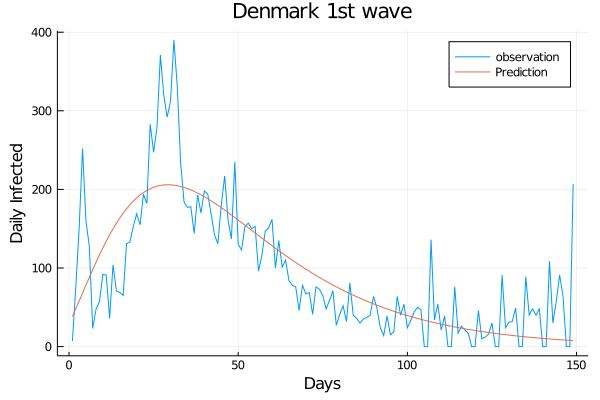

In [22]:
prediction(accumulated["Denmark"][1:150], r=-1.5, days=0, title="Denmark 1st wave")

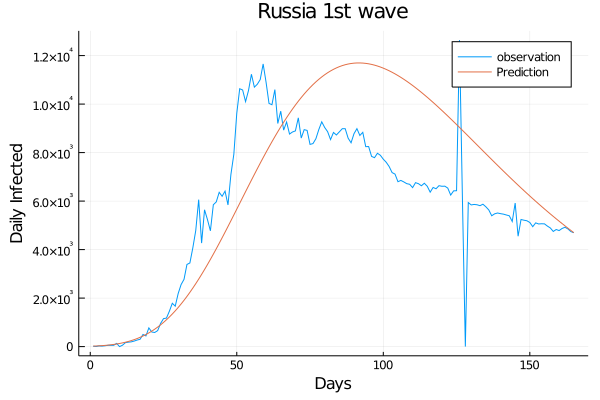

In [23]:
prediction(accumulated["Russia"][1:end], r=0.6, days=0, title="Russia 1st wave")

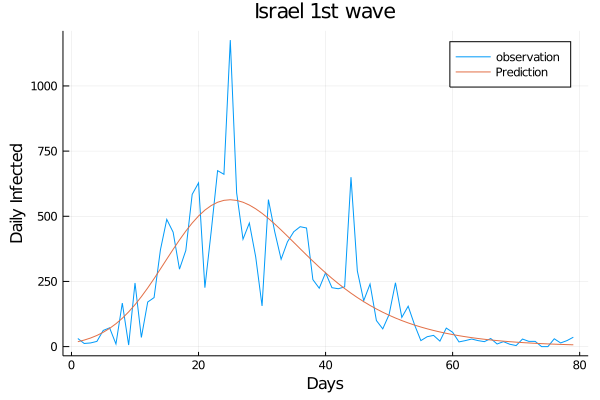

In [24]:
prediction(accumulated["Israel"][1:80], r=3.0, days=0, title="Israel 1st wave")

In [45]:
#prediction2(accumulated["Israel"][1:end], p=20, r=1.0, days=7, title="Israel multiwaves", position=:topleft)

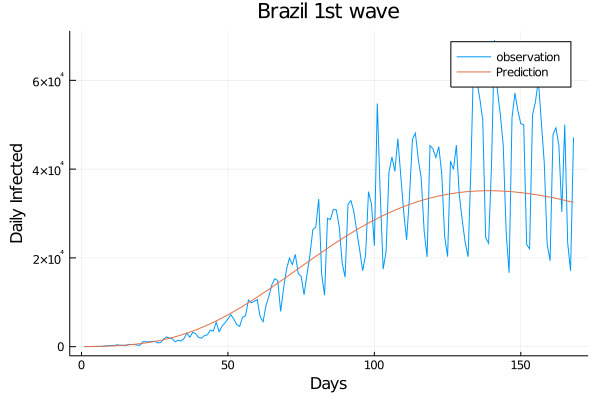

In [25]:
prediction(accumulated["Brazil"][1:169], r=-0.3, days=0, title="Brazil 1st wave")

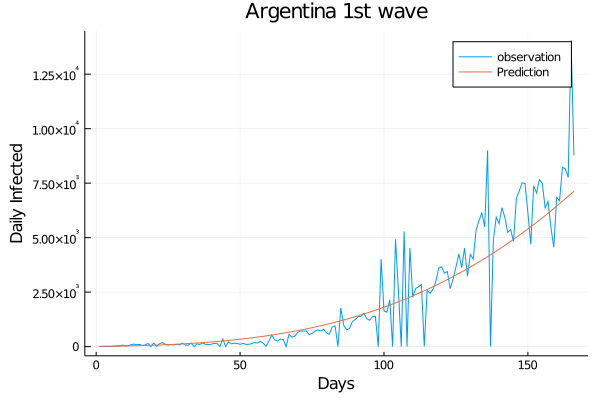

In [26]:
prediction(accumulated["Argentina"][1:167], r=-1.3, days=0, title="Argentina 1st wave")

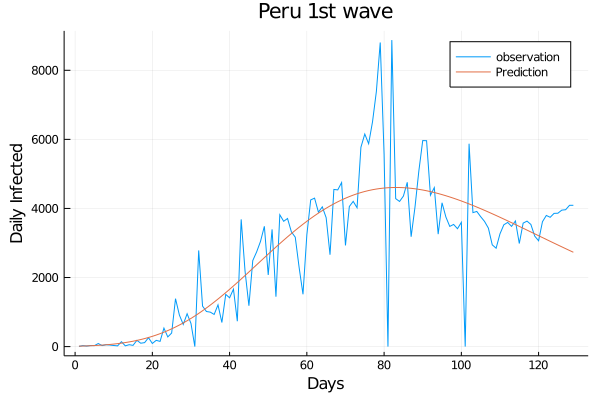

In [46]:
prediction(accumulated["Peru"][1:130], r=1.0, days=0, title="Peru 1st wave")

In [50]:
#prediction2(accumulated["Peru"][1:166], r=0.5, p=10, days=7, title="Peru multiwaves", position=:topleft)

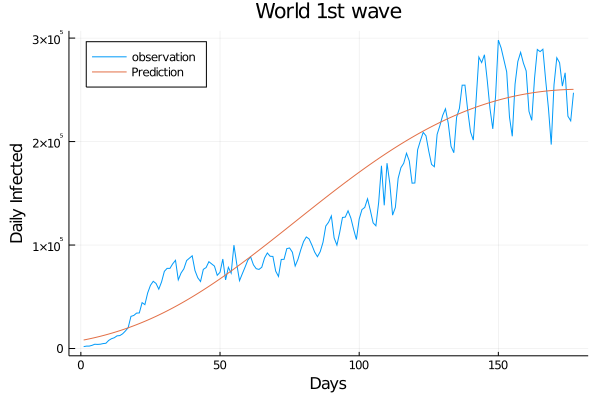

In [28]:
prediction(accumulated["World"][60:end], r=-0.4, days=0, title="World 1st wave", position=:topleft)